# Quasi-Newton methods: BFGS

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.optimize
import scipy as sp
import matplotlib.pyplot as plt

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

<ipython-input-1-03773fdb5cf9>:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


Consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), that is minimized in $\mathbf{x} = (1,1,\dots,1)^T$:

$$\mathcal{L}(\mathbf{x}) = \sum_{i=1}^{N-1} [100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2]$$

In [3]:
def loss(x):
    return jnp.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

Use `jax` to compute and compile the Rosenbrock function and its gradient.

In [4]:
grad = jax.grad(loss)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

In [5]:
N = 100
x = np.random.rand(N)*2

%timeit loss(x)
%timeit loss_jit(x)
%timeit grad(x)
%timeit grad_jit(x)

The slowest run took 91.75 times longer than the fastest. This could mean that an intermediate result is being cached.
839 µs ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.47 times longer than the fastest. This could mean that an intermediate result is being cached.
21.8 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
101 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached.
22.3 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Implement the BFGS method for the minimization of the Rosenbrock function.
Set a maximum of 1000 epochs and a stopping tolerance on the gradient eucledian norm of $10^{-8}$.

epochs: 523
error: 1.739e-12


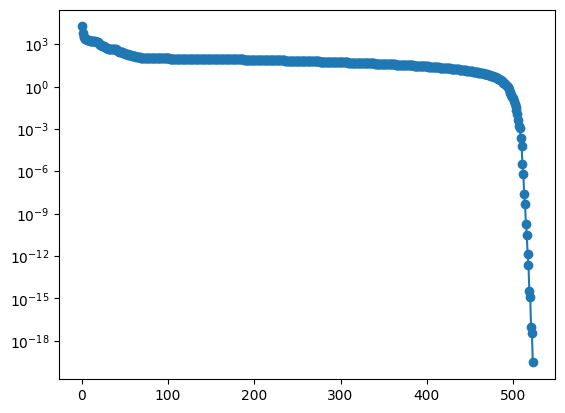

In [6]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x_guess = np.random.rand(N)*2

epoch = 0
grad = grad_jit(x_guess)
I = np.eye(N)
Binv = I        #approx of inv of hessian
x = x_guess
history = [loss_jit(x_guess)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    # search direction
    p = - Binv @ grad       #i dont solve a linear system, i alrdy have Binv

    # line search
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

x_ex = np.ones(N)
err = x - x_ex

print('epochs: %d' % epoch)
print('error: %1.3e' % (np.linalg.norm(err) / np.linalg.norm(x_ex)))
plt.semilogy(history, 'o-')

In [9]:
rho.shape, E.shape, y.shape

((), (100, 100), (100,))

In [8]:
rho

1.2658742168479123e+17